# Assignment 2

###### Created by Qihang Ma -- 2023.02.06


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Problem 1 - Exponentially Weighted Covariance Matrix

Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.

Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it.

Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λchosen.

What does this tell us about values of λ and the effect it has on the covariance matrix?

In [2]:
# Load the data
df = pd.read_csv("DailyReturn.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

#### Function for calculating an exponentially weighted covariance matrix

In [3]:
def exp_weighted_cov(returns, lambda_=0.97):
    """
    Perform calculation on the input data set with a given λ for exponentially weighted covariance.
    
    Parameters:
    - data: input data set, a pandas DataFrame
    - lambda_: fraction for unpdate the covariance matrix, default 0.97
    
    Returns:
    cov: an exponentially weighted covariance matrix, a numpy array
    """
    
    # Preprocess the data
    returns = returns.values
    mean_return = np.mean(returns, axis=0)
    normalized_returns = returns - mean_return
    
    # Initializing the covariance matrix
    n_timesteps, n_stocks = normalized_returns.shape
    cov = np.cov(returns, rowvar=False)
    
    # Updating the covariance matrix
    for t in range(1, n_timesteps):
        cov = lambda_ * cov + (1 - lambda_) * np.outer(normalized_returns[t], normalized_returns[t])
    return cov

In [4]:
def exp_weighted_cov_with_weight_matrix(returns, lambda_=0.97):
    """
    Perform calculation on the input data set with a given λ for exponentially weighted covariance.
    
    Parameters:
    - data: input data set, a pandas DataFrame
    - lambda_: fraction for unpdate the covariance matrix, default 0.97
    
    Returns:
    cov: an exponentially weighted covariance matrix, a numpy array
    """
    
    # Preprocess the data
    returns = returns.values
    mean_return = np.mean(returns, axis=0)
    normalized_returns = returns - mean_return
    
    # Initializing the covariance matrix
    n_timesteps, n_stocks = normalized_returns.shape
    weights = np.zeros(n_timesteps)
    
    # Compute the weight for each time step
    for t in range(n_timesteps):
        weights[n_timesteps-1-t]  = (1-lambda_)*lambda_**t
    
    # Normalize the weights_matrix
    weights_matrix = np.diag(weights/sum(weights))

    cov = np.transpose(normalized_returns) @ weights_matrix @ normalized_returns
    return cov

In [5]:
ew1 = exp_weighted_cov(df)
ew2 = exp_weighted_cov_with_weight_matrix(df)
print(np.allclose(ew1, ew2))


False


In [6]:
np.random.seed(0)
returns = np.random.normal(0, 1, (1000, 100))
returns = pd.DataFrame(returns)
ew1 = exp_weighted_cov(returns)
ew2 = exp_weighted_cov_with_weight_matrix(returns)
print(np.allclose(ew1, ew2))


True


#### Perform PCA and calculate the cumulative variance explained by given eigenvalue for λ chosen

In [7]:
def pca_cum_var(cov_matrix, n_components):
    """
    Perform PCA on the input data set and calculat the cumulative variance explained by a given components number.
    
    Parameters:
    - data: input data set, a numpy array with shape (n_samples, n_features)
    - λ: components number
    
    Returns:
    The cumulative variance explained by each eigenvalue for a given n.
    """
    # Compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Only consider eigenvalues greater than 0
    idx = eigenvalues > 1e-8
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Sort the eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate the cumulative variance explained by each eigenvalue
    cumulative_variance =(np.cumsum(eigenvalues[:n_components]) / np.sum(eigenvalues))[-1]
    
    return cumulative_variance

#### Plot the cumulative variance explained by each eigenvalue for each λ chosen

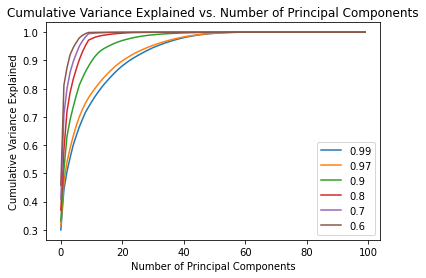

In [8]:
lambda_values = [0.99, 0.97, 0.9, 0.8, 0.7, 0.6]
cumulative_variances = []

for lambda_ in lambda_values:
    cov = exp_weighted_cov_with_weight_matrix(df, lambda_)
    cumulative_variance_for_lambda = []
    for n in range(1,101):
        cumulative_variance_for_lambda.append(pca_cum_var(cov, n))
    cumulative_variances.append(cumulative_variance_for_lambda)
    
# Plot the cumulative variance explained
plt.figure()
for cumulative_variance in cumulative_variances:
    plt.plot(cumulative_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained vs. Number of Principal Components")
plt.legend(lambda_values)
plt.savefig('PCA for lambda.png', dpi =300)
plt.show()


## Problem 2 - Decomposition for  PSD

Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice. These are core functions you will need throughout the remainder of the class.

Implement Higham’s 2002 nearest psd correlation function.

Generate a non-psd correlation matrix that is 500x500.

Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.

Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases?

Based on the above, discuss the pros and cons of each method and when you would use each. There is no wrong answer here, I want you to think through this and tell me what you think.

#### Cholesky Factorization 

In [9]:
def chol_psd(cov_matrix):
    """
    Perform Cholesky decomposition on the input matrix `covariance`.
    
    Parameters:
    - cov_matrix: input matrix, a numpy array with shape (n_samples, n_samples)
    
    Returns:
    The Cholesky decomposition of the input matrix `covariance`.
    """
    n = cov_matrix.shape[0]
    root = np.zeros_like(cov_matrix)
    for j in range(n):
        s = 0.0
        if j > 0:
            # calculate dot product of the preceeding row values
            s = np.dot(root[j, :j], root[j, :j])
        temp = cov_matrix[j, j] - s
        if 0 >= temp >= -1e-8:
            temp = 0.0
        root[j, j] = np.sqrt(temp)
        if root[j, j] == 0.0:
            # set the column to 0 if we have an eigenvalue of 0
            root[j + 1:, j] = 0.0
        else:
            ir = 1.0 / root[j, j]
            for i in range(j + 1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (cov_matrix[i, j] - s) * ir
    return root

#### Dealing with Non-PSD Matrices - Rebonato and Jackel

In [10]:
def near_psd(matrix, epsilon=0.0):
    """
    Calculates a near positive semi-definite (PSD) matrix from a given non-PSD matrix.

    Parameters:
    - matrix: The input matrix, a 2-dimensional numpy array
    - epsilon: A small non-negative value used to ensure that the resulting matrix is PSD, default value is 0.0

    Returns:
    The output of this function is a 2-dimensional numpy array that represents a near PSD matrix. 
    """
    n = matrix.shape[0]

    invSD = None
    out = matrix.copy()

    # calculate the correlation matrix if we got a covariance
    if np.count_nonzero(np.diag(out) == 1.0) != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = np.matmul(np.matmul(invSD, out), invSD)

    # SVD, update the eigen value and scale
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = np.reciprocal(np.matmul(np.square(vecs), vals))
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = np.matmul(np.matmul(T, vecs), l)
    out = np.matmul(B, np.transpose(B))

    # Add back the variance
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = np.matmul(np.matmul(invSD, out), invSD)

    return out

#### Dealing with Non-PSD Matrices - Higham

In [11]:
def Pu(matrix):
    """The first projection for Higham method with the assumption that weight martrix is diagonal."""
    result = matrix.copy()
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if i==j:
                result[i][i]=1
    return result

def Ps(matrix, weight):
    """The second projection for Higham method."""
    matrix = np.sqrt(weight)@ matrix @np.sqrt(weight)
    vals, vecs = np.linalg.eigh(matrix)
    vals = np.array([max(i,0) for i in vals])
    result = np.sqrt(weight)@ vecs @ np.diagflat(vals) @ vecs.T @ np.sqrt(weight)
    return result

def Frobenius_Norm(matrix_1, matrix_2):
    distance = matrix_1 - matrix_2
    result = 0
    for i in range(len(distance)):
        for j in range(len(distance)):
            result += distance[i][j]**2
    return result

def Higham_psd(matrix, weight = None, epsilon = 1e-9, max_iter = 1000, tolerance = 1e-8):
    """
    Calculates a near positive semi-definite (PSD) matrix from a given non-PSD matrix.

    Parameters:
    - matrix: The input covariance matrix, a 2-dimensional numpy array
    - weight: Assume weight is a diagonal matrix, if unweighted, set 𝑊 = 𝐼
    - epsilon: Used to check the smallest eigenvalue from the result
    - max_iter: Restriction on the maximum iteration loops
    - tolerance: A small non-negative value used to restrict the distance for the original matrix, default value is 1e-8

    Returns:
    The output of this function is a 2-dimensional numpy array that represents a nearest PSD matrix. 
    """
    if weight is None:
        weight = np.identity(len(matrix))
        
    norml = np.inf
    Yk = matrix.copy()
    Delta_S = np.zeros_like(Yk)
    
    invSD = None
    if np.count_nonzero(np.diag(Yk) == 1.0) != matrix.shape[0]:
        invSD = np.diag(1 / np.sqrt(np.diag(Yk)))
        Yk = np.matmul(np.matmul(invSD, Yk), invSD)
    
    Y0 = Yk.copy()

    for i in range(max_iter):
        Rk = Yk - Delta_S
        Xk = Ps(Rk, weight)
        Delta_S = Xk - Rk
        Yk = Pu(Xk)
        norm = Frobenius_Norm(Yk, Y0)
        minEigVal = np.real(np.linalg.eigvals(Yk)).min()
        if abs(norm - norml) < tolerance and minEigVal > -epsilon:
            break
        else:
            norml = norm
    
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        Yk = np.matmul(np.matmul(invSD, Yk), invSD)
    return Yk

#### Comparison on near_psd and Higham_psd

Generate a non-psd correlation matrix that is 500x500

In [12]:
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

Fix the matrix and Confirm the matrix is now PSD or not

In [13]:
def is_psd(matrix):
    """For a given matrix, check if the matrix is psd or not."""
    eigenvalues = np.linalg.eigh(matrix)[0]
    return np.all(eigenvalues >= -1e-8)

In [14]:
print("Original matrix: ", is_psd(sigma))
print("Matrix fixed with near_psd(): ", is_psd(near_psd(sigma)))
print("Matrix fixed with Higham_psd(): ", is_psd(Higham_psd(sigma)))

Original matrix:  False
Matrix fixed with near_psd():  True
Matrix fixed with Higham_psd():  True


Compare the results of both using the Frobenius Norm

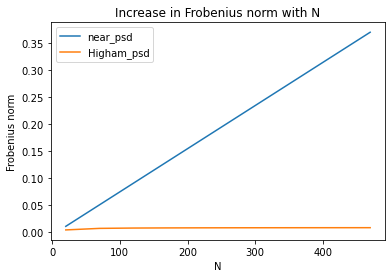

In [15]:
n_range = np.arange(20, 501, 50)
frobenius_norms_near = []
frobenius_norms_higham = []
for n_current in n_range:
    sigma_current = sigma[:n_current, :n_current]
    sigma_fixed_near = near_psd(sigma_current)
    frobenius_norm_near = Frobenius_Norm(sigma_current, sigma_fixed_near)
    frobenius_norms_near.append(frobenius_norm_near)
    
    sigma_fixed_higham = Higham_psd(sigma_current)
    frobenius_norm_higham = Frobenius_Norm(sigma_current, sigma_fixed_higham)
    frobenius_norms_higham.append(frobenius_norm_higham)


plt.plot(n_range, frobenius_norms_near, label='near_psd')
plt.plot(n_range, frobenius_norms_higham, label='Higham_psd')
plt.xlabel('N')
plt.ylabel('Frobenius norm')
plt.title('Increase in Frobenius norm with N')
plt.legend()
plt.savefig('Frobenius norm comparison.png', dpi =300)
plt.show()

Compare the run time between the two

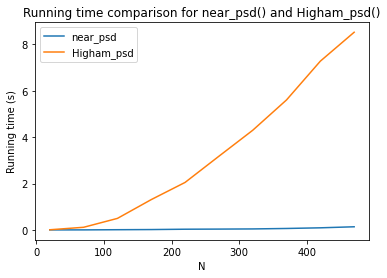

In [16]:
n_range = np.arange(20, 501, 50)
time_near_psd = []
time_higham_psd = []
for n_current in n_range:
    sigma_current = sigma[:n_current, :n_current]
    
    start_time = time.time()
    sigma_fixed_near = near_psd(sigma_current)
    time_near = time.time() - start_time
    time_near_psd.append(time_near)
    
    start_time = time.time()
    sigma_fixed_higham = Higham_psd(sigma_current)
    time_higham = time.time() - start_time
    time_higham_psd.append(time_higham)

plt.plot(n_range, time_near_psd, label='near_psd')
plt.plot(n_range, time_higham_psd, label='Higham_psd')
plt.xlabel('N')
plt.ylabel('Running time (s)')
plt.title('Running time comparison for near_psd() and Higham_psd()')
plt.legend()
plt.savefig('Running time comparison.png', dpi =300)
plt.show()

## Problem 3 - Simulation Practice 

Using DailyReturn.csv.

Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.

Generate a correlation matrix and variance vector 2 ways:
1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and
var() functions).
2. Exponentially weighted λ = 0. 97

Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.)


Simulate 25,000 draws from each covariance matrix using:
1. Direct Simulation
2. PCA with 100% explained.
3. PCA with 75% explained.
4. PCA with 50% explained.

Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices). Compare the run times for each simulation.

What can we say about the trade offs between time to run and accuracy.

####  Implement multivariate normal simulation

In [17]:
def multivariate_normal_simulation(covariance_matrix, n_samples, method='direct', mean = 0, explained_variance=1.0):
    """
    A function to simulate multivariate normal distributions with different methods.
    
    Parameters:
    - covariance_matrix (np.array): The covariance matrix for the multivariate normal distribution
    - n_samples (int): The number of samples to generate
    - method (str, optional): The method to use for simulation, either 'direct' or 'pca', default 'direct'
         'direct': simulate directly from the covariance matrix.
         'pca': simulate using principal component analysis (PCA).
    - explained_variance (float, optional): The percentage of explained variance to keep when using PCA, default 1.0
    
    Returns:
     np.array: An array with shape (covariance_matrix.shape[0], n_samples) with the simulated samples.
    """
    
    # If the method is 'direct', simulate directly from the covariance matrix
    if method == 'direct':
        
        L = chol_psd(covariance_matrix)
        normal_samples = np.random.normal(size=(covariance_matrix.shape[0], n_samples))
        
        samples = np.transpose(np.dot(L, normal_samples) + mean)
        
        return samples
    
    # If the method is 'pca', simulate using PCA
    elif method == 'pca':
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Only consider eigenvalues greater than 0
        idx = eigenvalues > 1e-8
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Sort the eigenvalues in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Update the explained_variance incase the explained_variance is higher than the cumulative sum of the eigenvalue
        if explained_variance == 1.0:
            explained_variance = (np.cumsum(eigenvalues)/np.sum(eigenvalues))[-1]
        
        # Determine the number of components to keep based on the explained variance ratio
        n_components = np.where((np.cumsum(eigenvalues)/np.sum(eigenvalues))>= explained_variance)[0][0] + 1
        eigenvectors = eigenvectors[:,:n_components]
        eigenvalues = eigenvalues[:n_components]

        normal_samples = np.random.normal(size=(n_components, n_samples))
        
        # Simulate the multivariate normal samples by multiplying the eigenvectors with the normal samples
        B = np.dot(eigenvectors, np.diag(np.sqrt(eigenvalues)))
        samples = np.transpose(np.dot(B, normal_samples))
        
        return samples

#### Four ways to generate the covariance matrix

In [18]:
def exp_weighted_correlation_pearson_var(returns, lambda_=0.97):
    """
    Calculate exponentially weighted correlation matrix with Pearson variance.
    
    Parameters:
    - returns: input data set, a pandas DataFrame
    - lambda_: fraction for update the covariance matrix, default 0.97
    
    Returns:
    cov: exponentially weighted correlation matrix with Pearson variance, a numpy array
    """
    cov = exp_weighted_cov_with_weight_matrix(returns, lambda_)
        
    # Calculate the correlation matrix
    corr = np.diag(np.reciprocal(np.sqrt(np.diag(cov)))) @ cov @ np.diag(np.reciprocal(np.sqrt(np.diag(cov)))).T
    
    # Calculate the variance
    var = np.var(returns)
    std_dev = np.sqrt(var)
    
    # Multiply the correlation matrix with the variance
    cov = np.outer(std_dev, std_dev) * corr
    return cov


In [19]:
def pearson_correlation_exp_weighted_var(returns, lambda_=0.97):
    """
    Calculate Pearson correlation matrix with exponentially weighted variance.
    
    Parameters:
    - returns: input data set, a pandas DataFrame
    - lambda_: fraction for update the covariance matrix, default 0.97
    
    Returns:
    cov: Pearson correlation matrix with exponentially weighted variance, a numpy array
    """
 
    cov = exp_weighted_cov_with_weight_matrix(returns, lambda_)
        
    # Calculate the standard deviation
    std_dev = np.sqrt(np.diag(cov))
    
    # Calculate the correlation matrix
    corr = np.corrcoef(returns.T)
    
    # Multiply the correlation matrix with the variance
    cov = np.outer(std_dev, std_dev) * corr
    return cov


#### Run the simulation and do the comparison

In [20]:
def compare_covariance_matrices(covariance_matrix, method, explained_variance=1.0):
    n_samples = 25000
    
    start_time = time.time()
    samples = multivariate_normal_simulation(covariance_matrix, n_samples, method=method, explained_variance=explained_variance)
    elapsed_time = time.time() - start_time
    
    simulated_covariance = np.cov(samples, rowvar=False)
    error = Frobenius_Norm(simulated_covariance, covariance_matrix)
    
    return elapsed_time, error


In [21]:
def simulation_and_plotting(covariance_matrix, title, ax):
    np.random.seed(0)
    explained_variances = [1.0, 0.75, 0.5]
    
    elapsed_times = []
    errors = []
    labels = []
    
    elapsed_time, error = compare_covariance_matrices(covariance_matrix, 'direct')
    elapsed_times.append(elapsed_time)
    errors.append(error)
    labels.append("direct")
    
    for explained_variance in explained_variances:
        elapsed_time, error = compare_covariance_matrices(covariance_matrix, 'pca', explained_variance)
        elapsed_times.append(elapsed_time)
        errors.append(error)
        labels.append("pca: {}".format(explained_variance))
            
    ax.plot(elapsed_times, errors, 'o-')
    
    for i, label in enumerate(labels):
        ax.annotate(label, (elapsed_times[i], errors[i]))
        
    ax.set_xlabel('Elapsed Time (s)')
    ax.set_ylabel('Frobenius Norm')
    ax.set_title('Trade-off for: {}'.format(title))
    

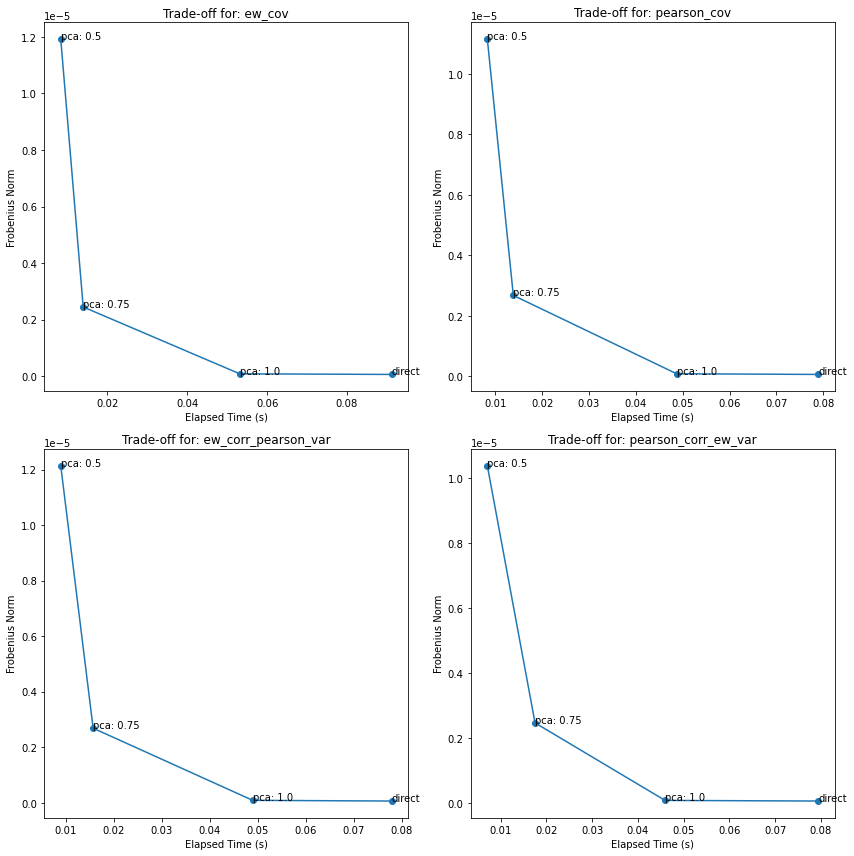

In [22]:
ew_cov = exp_weighted_cov_with_weight_matrix(df)
pearson_cov = np.cov(df, rowvar=False)
ew_corr_pearson_var = exp_weighted_correlation_pearson_var(df)
pearson_corr_ew_var = pearson_correlation_exp_weighted_var(df)


matrixes = [ew_cov, pearson_cov, ew_corr_pearson_var, pearson_corr_ew_var]
matrixes_name = ['ew_cov', 'pearson_cov', 'ew_corr_pearson_var', 'pearson_corr_ew_var']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for matrix, matrix_name, ax in zip(matrixes, matrixes_name, axs):
    simulation_and_plotting(matrix, matrix_name, ax)

plt.tight_layout()
plt.savefig('Trade-off between Time and Accuracy.png', dpi =300)
plt.show()